In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
## Create Phased Array
d = 0.5 # Inter element spacing [lambda]
M = 2  # number of antenna elements in the antenna system (ULA)

#Test Signal Parameters
N = 2**12 # Samples used for test signal
azimuth = 60; # Incidence azimuth
elevation = 90; # Incidence elevation

# Array response vectors of the test signal broken into x,y subsets
x1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(azimuth)))
x2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(azimuth)))
y1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(elevation)))
y2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(elevation)))

# TEST
print(x1)
print(y1)

[ 1.0000000e+00+0.j -3.8285687e-16+1.j]
[1.+0.00000000e+00j 1.+1.92367069e-16j]


x1: (4096,) 
 [-0.14473859 -0.85827461  1.28987183 ... -0.69513706  0.43500321
  1.85922408]
x1 (multi): (2, 4096) 
 [[ 1.81922888e+00+0.j          6.38748908e-01+0.j
  -3.85813784e-01+0.j         ... -6.95137064e-01+0.j
   4.35003213e-01+0.j          1.85922408e+00+0.j        ]
 [-6.96504276e-16+1.81922888j -2.44549408e-16+0.63874891j
   1.47711458e-16-0.38581378j ...  2.66138000e-16-0.69513706j
  -1.66543968e-16+0.43500321j -7.11816713e-16+1.85922408j]]


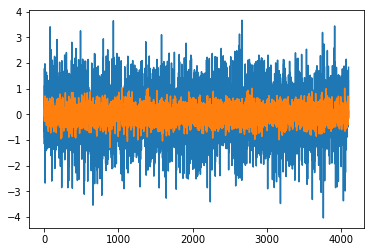

In [19]:
# Generate multichannel test signal for x1
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer(soi, x1).T 

# TEST
print('x1:', soi.shape, '\n', soi[4:])
print('x1 (multi):', soi_matrix.shape, '\n', soi_matrix[:4])

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_x1 = soi_matrix + noise

plt.plot(rec_signal_x1.T)

# Generate multichannel test signal for x2
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, x2).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_x2 = soi_matrix + noise

# Generate multichannel test signal for y1
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, y1).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_y1 = soi_matrix + noise

# Generate multichannel test signal for y2
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, y2).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal_y2 = soi_matrix + noise

In [5]:
# Calculate Correlation Coefficient
R_x1 = np.corrcoef(rec_signal_x1)
R_x2 = np.corrcoef(rec_signal_x2)
R_y1 = np.corrcoef(rec_signal_y1)
R_y2 = np.corrcoef(rec_signal_y2)

In [6]:
# Steering Vector Function
def gen_steering_vectors(array_alignment, thetas):
    M = np.size(array_alignment, 0)  # Number of antenna elements    
    steering_vectors = np.zeros((M, np.size(thetas)), dtype=complex)
    for i in range(np.size(thetas)):    
        steering_vectors[:, i] = np.exp(array_alignment*1j*2*np.pi*np.cos(np.radians(thetas[i]))) # Scanning vector      
        
    return steering_vectors

In [7]:
# Calulate Steering Vector
array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
steering_vectors = gen_steering_vectors(array_alignment, incident_angles)

In [8]:
# DoA Estimation Function
def DoA_MVDR(R,steering_vectors):
    R_inv  = np.linalg.inv(R) # invert the cross correlation matrix
    theta_index=0
    ADSINR = np.zeros(np.size(steering_vectors,1))
    for i in range(np.size(steering_vectors, 1)):             
        S_theta_ = steering_vectors[:, i]
        ADSINR[theta_index]=np.dot(np.conj(S_theta_),np.dot(R_inv,S_theta_))
        theta_index += 1
    
    ADSINR = np.reciprocal(ADSINR)
        
    return ADSINR

In [9]:
DoA_Azimuth_1 = DoA_MVDR(R_x1,steering_vectors)
DoA_Azimuth_2 = DoA_MVDR(R_x2,steering_vectors)
DoA_Elevation_1 = DoA_MVDR(R_y1,steering_vectors)
DoA_Elevation_2 = DoA_MVDR(R_y2,steering_vectors)

/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


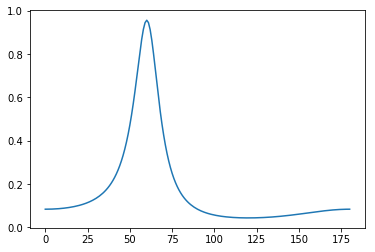

In [10]:
plt.plot(DoA_Azimuth_1)

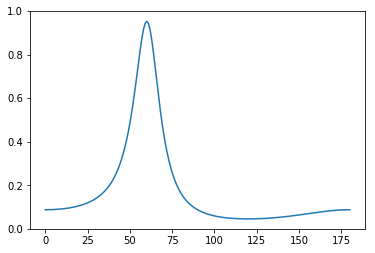

In [11]:
plt.plot(DoA_Azimuth_2)

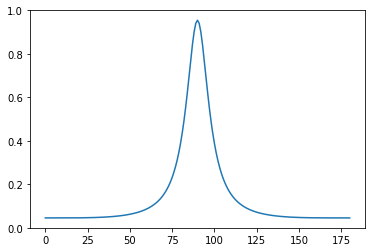

In [12]:
plt.plot(DoA_Elevation_1)

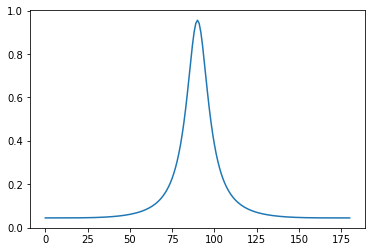

In [13]:
plt.plot(DoA_Elevation_2)

In [14]:
DoA_Azimuth_Array = 0.5*(DoA_Azimuth_1 + DoA_Azimuth_2)
DoA_Elevation_Array = 0.5*(DoA_Elevation_1 + DoA_Elevation_2)

In [15]:
DoA_Azimuth = np.argmax(DoA_Azimuth_Array)
DoA_Elevation = np.argmax(DoA_Elevation_Array)

In [16]:
print(DoA_Azimuth)
print(DoA_Elevation)

60
90


In [17]:
def MVDR_1D_Beamformer_Weights(theta,steering_vectors,R):
    R_inv  = np.linalg.inv(R) # invert the cross correlation matrix
    S_theta = steering_vectors[:, theta]
    weights = np.dot(R_inv,S_theta)/np.dot(np.conj(S_theta),np.dot(R_inv,S_theta))
    
    return weights

In [18]:
weights_x1 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Azimuth,steering_vectors,R_x1),[2,1])
weights_x2 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Azimuth,steering_vectors,R_x2),[2,1])
weights_y1 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Elevation,steering_vectors,R_y1),[2,1])
weights_y2 = np.reshape(MVDR_1D_Beamformer_Weights(DoA_Elevation,steering_vectors,R_y2),[2,1])

In [19]:
print(weights_x1)
print(weights_x2)
print(weights_y1)
print(weights_y2)

[[ 0.5      -0.0028925j]
 [-0.0028925+0.5j      ]]
[[ 0.5       -0.00352814j]
 [-0.00352814+0.5j       ]]
[[0.5-1.60847024e-17j]
 [0.5+1.12268237e-16j]]
[[0.5-6.41130147e-18j]
 [0.5+1.02594836e-16j]]


In [20]:
def MVDR_1D_Beamformer(rec_signal_1, rec_signal_2, weights_1, weights_2):
    updated_rec_signal_1 = np.dot(rec_signal_1.T,weights_1)
    print(np.shape(updated_rec_signal_1))
    updated_rec_signal_2 = np.dot(rec_signal_2.T,weights_2)
    updated_rec_signal_total = updated_rec_signal_1 + updated_rec_signal_2
    
    return updated_rec_signal_total

In [26]:
final_updated_signal_xdirection = MVDR_1D_Beamformer(rec_signal_x1,rec_signal_x2,weights_x1,weights_x2)
final_updated_signal_ydirection = MVDR_1D_Beamformer(rec_signal_y1,rec_signal_y2,weights_y1,weights_y2)

(4096, 1)
(4096, 1)


/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


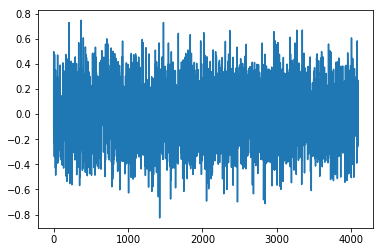

In [27]:
plt.plot(final_updated_signal_xdirection)

/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


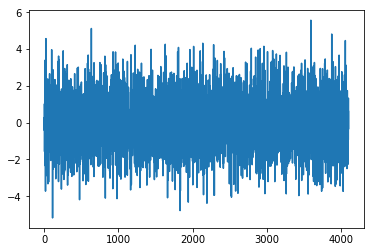

In [28]:
plt.plot(final_updated_signal_ydirection)